<a href="https://colab.research.google.com/github/dohyeonkim2526/BigContest/blob/master/predict_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random forest로 코드(마더코드 뒤에 3개 + 상품코드 뒤에 3개) 예측

그 정보를 토대로 코드, 상품군, 년도, 월 ,요일 을 라벨링 하고 판매단가는 그대로 두고 Decision Tree로 취급액 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data cleansing

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
performance = pd.read_excel('/content/drive/My Drive/2019_performance.xlsx')   ## 제공 데이터 로드
performance_test = pd.read_excel('/content/drive/My Drive/performance_test.xlsx')  ## 평가 데이터 로드

In [ ]:
performance

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2019-01-01 06:00:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0
2,2019-01-01 06:20:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0
4,2019-01-01 06:40:00,20.000000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0
...,...,...,...,...,...,...,...,...
38304,2020-01-01 00:20:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38305,2020-01-01 00:40:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38306,2020-01-01 01:00:00,20.000000,100073,200196,삼성화재 행복한파트너 주택화재보험(1912),무형,0,NaN
38307,2020-01-01 01:20:00,20.000000,100490,201478,더케이 예다함 상조서비스(티포트),무형,0,NaN


In [ ]:
## 상품군이 무형인 행 전체 삭제
del_idx = performance[performance['상품군']=='무형'].index
del_1 = performance.drop(del_idx)

In [ ]:
## 방송일시를 세부 항목으로 분할 후 새로운 열 생성
del_1['year']=del_1['방송일시'].dt.year
del_1['month']=del_1['방송일시'].dt.month
del_1['day']=del_1['방송일시'].dt.day_name()
del_1['hour']=del_1['방송일시'].dt.hour
del_1['min']=del_1['방송일시'].dt.minute

In [ ]:
# 인덱스 재부여
del_1=del_1.reset_index(drop=True)
del_1

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,Tuesday,6,0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,Tuesday,6,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,Tuesday,6,20
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,Tuesday,6,20
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,Tuesday,6,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019,12,Tuesday,23,40
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020,1,Wednesday,0,0
37369,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020,1,Wednesday,0,0
37370,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020,1,Wednesday,0,0


In [ ]:
## 토요일 18시 행 삭제
sat = []
for i in range(del_1.shape[0]):
  row = del_1.iloc[i]
  row_day = row['day']
  row_hour = row['hour']
  row_min = row['min']
  if row_day == 'Saturday':
    if row_hour == 18:
      if row_min == 0 or row_min == 20:
        sat.append(i)
  else:
    continue

In [ ]:
for i in range(del_1.shape[0]):
  if i in sat:
    del_1=del_1.drop(i,axis=0)

In [ ]:
del_sat=del_1.reset_index(drop=True)

In [ ]:
## 토요일 18시 데이터가 사라진 제공 데이터
del_sat

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,Tuesday,6,0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,Tuesday,6,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,Tuesday,6,20
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,Tuesday,6,20
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,Tuesday,6,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37344,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019,12,Tuesday,23,40
37345,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020,1,Wednesday,0,0
37346,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020,1,Wednesday,0,0
37347,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020,1,Wednesday,0,0


In [ ]:
## 판매개수(필요할진 모르겠지만), 코드(마더코드 뒤에 3개, 상품코드 뒤에 3개)의 새로운 열 생성 
plus_section = del_sat.reindex(columns=[*del_sat.columns.tolist(), '판매개수','코드'], fill_value=0)
plus_section

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min,판매개수,코드
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,Tuesday,6,0,0,0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,Tuesday,6,0,0,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,Tuesday,6,20,0,0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,Tuesday,6,20,0,0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,Tuesday,6,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37344,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019,12,Tuesday,23,40,0,0
37345,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020,1,Wednesday,0,0,0,0
37346,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020,1,Wednesday,0,0,0,0
37347,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020,1,Wednesday,0,0,0,0


In [ ]:
for i, (p ,q) in enumerate(zip(plus_section['취급액'],plus_section['판매단가'])):
  plus_section['판매개수'].iloc[i] = int(int(p)/int(q))
  plus_section['코드'].iloc[i] = int(str(plus_section['마더코드'].iloc[i])[-3:]+str(plus_section['상품코드'].iloc[i])[-3:])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
plus_section

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min,판매개수,코드
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019,1,Tuesday,6,0,52,346072
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019,1,Tuesday,6,0,109,346079
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,2019,1,Tuesday,6,20,81,346072
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,2019,1,Tuesday,6,20,174,346079
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,2019,1,Tuesday,6,40,167,346072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37344,2019-12-31 23:40:00,NaN,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,2019,12,Tuesday,23,40,68,448391
37345,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,2020,1,Wednesday,0,0,286,448383
37346,2020-01-01 00:00:00,NaN,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,2020,1,Wednesday,0,0,621,448390
37347,2020-01-01 00:00:00,NaN,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,2020,1,Wednesday,0,0,87,448384


## Modeling

In [ ]:
## 한국어 토큰화 패키지 다운로드
!pip install konlpy

  Using cached https://files.pythonhosted.org/packages/85/0e/f385566fec837c0b83f216b2da65db9997b35dd675e107752005b7d392b1/konlpy-0.5.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bb/7c/99d51f80f3b77b107ebae2634108717362c059a41384a1810d13e2429a81/tweepy-3.9.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c9/dc/45cdef1b4d119eb96316b3117e6d5708a08029992b2fee2c143c7a0a5cc5/colorama-0.4.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8b/f7/a368401e630f0e390dd0e62c39fb928e5b23741b53c2360ee7d376660927/JPype1-1.0.2-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9e/d4/10f46e5cfac773e22707237bfcd51bbffeaf0a576b0a847ec7ab15bd7ace/beautifulsoup4-4.6.0-py3-none-any.whl
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulso

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
## 한국어 불용어 사전 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
## 상품명 데이터 전체 토큰화 및 불용어 제거
okt = Okt()
tokenized_data = []
for sentence in plus_section['상품명']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [ ]:
vocab = list(set(w for i in tokenized_data for w in i ))
vocab.sort()

In [ ]:
## 전체 단어의 갯수 
len(vocab)

2248

리뷰의 최대 길이 : 26
리뷰의 평균 길이 : 9.270930948619776


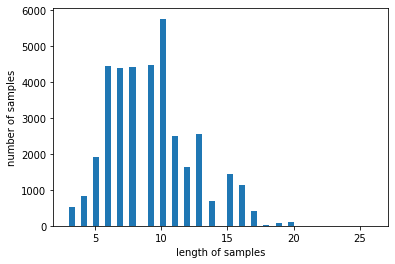

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
product_name = plus_section['상품명']
price = plus_section['취급액']
code = plus_section['코드']

In [ ]:
## 코드종류의 수
y = np.zeros((len(tokenized_data), ))
i = 0
for target in code:           
    y[i] = int(target)        
    i += 1

n_y = np.unique(y)
n_y

array([     0.,   1001.,   2002., ..., 849510., 849512., 849513.])

In [ ]:
## 토큰을 모두 연결시켜 문장화
def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

corp = corpus(tokenized_data)

In [ ]:
## 상품명 데이터의 본문을 TF-IDF 행렬로 변환하여 학습에 적용될수 있게 한다. 종속변수는 code

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
X = tf_idf_vectorizer.fit_transform(corp)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, code, test_size = 0.2, random_state = 77)

In [ ]:
X.shape

(37349, 1863)

In [ ]:
## 랜덤포레스트 이용 모델 피팅
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(bootstrap=True, n_estimators=30, verbose=2,
                                    n_jobs=-1, class_weight = 'balanced')
rf_clf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 30building tree 2 of 30

building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=2,
                       warm_start=False)

In [ ]:
rf_clf.score(x_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    2.1s finished


0.7344042838018742

In [ ]:
y_pred_probs = rf_clf.predict_proba(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    2.1s finished


In [ ]:
# # TOP  - 3 score
# cnt = 0
# for i in range(len(y_test)): #0.
#   top_3_label = [] # 리스트 초기화 해줌
#   top_3_label = y_pred_probs[i].argsort()[::-1][0:3] # 상위 3개 리스트로 넣어줌

#   if list(y_test)[i] in top_3_label:
#     cnt+=1
    
# print('TOP 3:', cnt/len(y_test))

# # TOP - 5 score
# cnt_5 = 0
# for i in range(len(y_test)):
#   top_5_label = [] # 리스트 초기화 해줌
#   top_5_label = y_pred_probs[i].argsort()[::-1][0:5] # 상위 5개 리스트로 넣어줌
   
#   if list(y_test)[i] in top_5_label:
#     cnt_5+=1
# print('TOP 5:', cnt_5/len(y_test))

TOP 3: 0.0002677376171352075
TOP 5: 0.0002677376171352075


In [ ]:
## 모델 평가 지표
import sklearn.metrics as metrics


y_pred = rf_clf.predict(x_test)

print('accuracy', metrics.accuracy_score(y_test, y_pred) )

print('precision', metrics.precision_score(y_test, y_pred, average='weighted'))

print('recall', metrics.recall_score(y_test, y_pred, average='weighted'))

print('f1', metrics.f1_score(y_test, y_pred, average='weighted'))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


accuracy 0.7344042838018742
precision 0.6644381959330897
recall 0.7344042838018742
f1 0.6860504501299132


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NEW INPUT

In [ ]:
## 평가데이터
performance_test

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,NaN
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN


In [ ]:
## 평가데이터와 같은 형태로 전처리
del_idx = performance_test[performance_test['상품군']=='무형'].index
del_t = performance_test.drop(del_idx)

In [ ]:
del_t['year']=del_t['방송일시'].dt.year
del_t['month']=del_t['방송일시'].dt.month
del_t['day']=del_t['방송일시'].dt.day_name()
del_t['hour']=del_t['방송일시'].dt.hour
del_t['min']=del_t['방송일시'].dt.minute

In [ ]:
sat = []
for i in range(del_t.shape[0]):
  row = del_t.iloc[i]
  row_day = row['day']
  row_hour = row['hour']
  row_min = row['min']
  if row_day == 'Saturday':
    if row_hour == 18:
      if row_min == 0 or row_min == 20:
        sat.append(i)
  else:
    continue

In [ ]:
for i in range(del_t.shape[0]):
  if i in sat:
    del_t=del_t.drop(i,axis=0)

In [ ]:
test_plus_section = del_t.reindex(columns=[*del_t.columns.tolist(), '판매개수','코드'], fill_value=0)
test_plus_section

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min,판매개수,코드
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,6,20,0,0
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,6,40,0,0
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,7,0,0,0
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,Monday,7,20,0,0
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,Monday,7,40,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,2020,7,Wednesday,0,10,0,0
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,2020,7,Wednesday,0,10,0,0
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,2020,7,Wednesday,0,10,0,0
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,2020,7,Wednesday,1,20,0,0


In [ ]:
test_tokenized_data = []
for sentence in test_plus_section['상품명']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    test_tokenized_data.append(temp_X)

In [ ]:
test_corp = corpus(test_tokenized_data)

In [ ]:
t_X = tf_idf_vectorizer.fit_transform(test_corp)
#new = np.empty((1, ), dtype= list)   # (1, ~) 벡터 만들기

t_X.toarray().shape

(2712, 777)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from tqdm import tqdm

In [ ]:
## 코드를 예측하기 위해서 단어 별로 인덱스 부여후 다시 그 단어를 불러 오기 위해서 W2V 모델을 적용하여 단어 생성
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 3, workers = 4, sg = 0)

In [ ]:
## 단어 사전 생성
index2word = {i+2: w for i, w in enumerate(model.wv.index2word)} 
index2word[0] = 'PAD'
index2word[1] = 'UNK'
word2index = {w: i for i, w in index2word.items() }
vocab_size = len(vocab) + 2

In [ ]:
## 평가데이터에 코드 예측하여 데이터프레임에 값을 부여
i=0
for input in tqdm(test_corp):

  new = np.empty((1, ), dtype= list)   # (1, ~) 벡터 만들기

  words = nltk.word_tokenize(input)
  seq = []
  for word in words:
    if word in word2index:
      seq.append(word2index[word])
    else:
      seq.append(word2index["UNK"])
  new[0] = seq

  new_input = sequence.pad_sequences(new, maxlen=X.shape[1]) 
  test_plus_section['코드'].iloc[i] = rf_clf.predict(new_input)
  i+=1

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 74%|███████▎  | 1998/2712 [03:33<01:15,  9.40it/s][Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
 74%|███████▎  | 1999/2712 [03:33<01:15,  9.42it/s][Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [ ]:
test_plus_section

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min,판매개수,코드
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,6,20,0,192661
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,6,40,0,192661
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,2020,6,Monday,7,0,0,192661
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,Monday,7,20,0,192661
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,2020,6,Monday,7,40,0,192661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,2020,7,Wednesday,0,10,0,192661
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,2020,7,Wednesday,0,10,0,192661
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,2020,7,Wednesday,0,10,0,192661
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,2020,7,Wednesday,1,20,0,192661


In [ ]:
## 필요한 열만 가져와서 분석 진행
train_df = plus_section[['코드','상품군','month','day','hour','판매단가']]

In [ ]:
## 명목형 변수로서 라벨 인코딩 하기위해서 int 데이터들을 str화 한다.
train_df = train_df.astype({'코드': 'str','month': 'str','hour': 'str'})

In [ ]:
from sklearn.preprocessing import LabelEncoder

def labeling(train_df):
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(train_df['상품군'])
  encoded_1 = encoder.transform(train_df['상품군'])
  encoder.fit(train_df['month'])
  encoded_2 = encoder.transform(train_df['month'])
  encoder.fit(train_df['day'])
  encoded_3 = encoder.transform(train_df['day'])
  encoder.fit(train_df['hour'])
  encoded_4 = encoder.transform(train_df['hour'])
  encoder.fit(train_df['코드'])
  encoded_5 = encoder.transform(train_df['코드'])

  train_df['상품군'] = encoded_1
  train_df['month'] = encoded_2
  train_df['day'] = encoded_3
  train_df['hour'] = encoded_4
  train_df['코드'] = encoded_5

  return train_df

In [ ]:
labeling(train_df)

,코드,상품군,month,day,hour,판매단가
0,732,6,0,5,17,39900
1,739,6,0,5,17,39900
2,732,6,0,5,17,39900
3,739,6,0,5,17,39900
4,732,6,0,5,17,39900
...,...,...,...,...,...,...
37344,1028,9,3,5,16,148000
37345,1023,9,0,6,0,178000
37346,1027,9,0,6,0,168000
37347,1024,9,0,6,0,158000


In [ ]:
test_df = test_plus_section[['코드','상품군','month','day','hour','판매단가']]

In [ ]:
test_df = test_df.astype({'코드': 'str','month': 'str','hour': 'str'})

In [ ]:
저## 마지막으로 디시전 트리를 이용해서 취급액 예측
from sklearn.tree import DecisionTreeRegressor


dt_model = DecisionTreeRegressor(max_depth=60, max_features=5, min_samples_leaf=3)
dt_model.fit(train_df, price)
from sklearn.tree import DecisionTreeRegressor


dt_model = DecisionTreeRegressor(max_depth=60, max_features=5, min_samples_leaf=3)
dt_model.fit(train_df, price)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=60,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
price_pred=dt_model.predict(labeling(test_df))

In [ ]:
len(price_pred)

2712

In [ ]:
for i, p in enumerate(price_pred):
  test_plus_section['취급액'].iloc[i] = int(p)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
test_plus_section

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,year,month,day,hour,min,판매개수,코드
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,21691333.0,2020,6,Monday,6,20,0,192661
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,21691333.0,2020,6,Monday,6,40,0,192661
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,21691333.0,2020,6,Monday,7,0,0,192661
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,21691333.0,2020,6,Monday,7,20,0,192661
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,21691333.0,2020,6,Monday,7,40,0,192661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,14922500.0,2020,7,Wednesday,0,10,0,192661
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,14922500.0,2020,7,Wednesday,0,10,0,192661
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,14922500.0,2020,7,Wednesday,0,10,0,192661
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,4120000.0,2020,7,Wednesday,1,20,0,192661
